# Predict Weather using some ML algorithm


---


By Mauricio Hernandez

Goal(s):
- Predict weather variables

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
#Connect to google drive
drive.mount('/content/gdrive')
#access path where notebook is stored
local_path = "/content/gdrive/MyDrive/Women In Technology/Niharika Yalla/"
#local_path = "/content/gdrive/MyDrive/Lumiere Program/Niharika Yalla/Code/"
#Change the working directory to the folder
os.chdir(local_path)

Mounted at /content/gdrive


In [4]:
project_path = Path(local_path).absolute()

input_data_path = project_path.joinpath('Data', 'Inputs')
output_data_path = project_path.joinpath('Data', 'Outputs')
print(input_data_path)

/content/gdrive/MyDrive/Women In Technology/Niharika Yalla/Data/Inputs


In [5]:
data_filename = 'weather_forec_and_actuals.csv'

#reading actuals and forecasts of all cities
df = pd.read_csv(output_data_path.joinpath(data_filename), parse_dates=['dt', 'dt_forecast_made'], index_col=0)
df.head()

,dt,city,temp_actual,humidity_actual,clouds_actual,visibility_actual,dt_forecast_made,dt_hours_diff,temp_forec,humidity_forec,clouds_forec,visibility_forec,error
683,2023-10-25 17:00:00,Los Angeles,291.43,83,100,10000.0,2023-10-25 13:58:33,3,291.88,80,100,10000,-0.45
684,2023-10-25 18:00:00,Los Angeles,292.16,79,100,10000.0,2023-10-25 13:58:33,4,291.91,82,100,10000,0.25
685,2023-10-25 19:00:00,Los Angeles,293.27,74,100,10000.0,2023-10-25 13:58:33,5,292.06,79,100,10000,1.21
686,2023-10-25 20:00:00,Los Angeles,294.22,69,100,10000.0,2023-10-25 13:58:33,6,292.32,75,100,10000,1.90
687,2023-10-25 21:00:00,Los Angeles,294.58,66,100,10000.0,2023-10-25 13:58:33,7,292.64,71,100,10000,1.94


In [36]:
#create subset for city = 'Los Angeles'
df_LA = df[df.city == 'Sacramento'].copy()
#sort data by 'dt'
df_LA.sort_values(by='dt', inplace=True)
#get day and hour from dt and create new columns
#df_LA['day'] = df_LA.dt.dt.day
df_LA['dayofweek'] = df_LA.dt.dt.dayofweek
df_LA['hour'] = df_LA.dt.dt.hour


In [37]:
df_LA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 101
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dt                 102 non-null    datetime64[ns]
 1   city               102 non-null    object        
 2   temp_actual        102 non-null    float64       
 3   humidity_actual    102 non-null    int64         
 4   clouds_actual      102 non-null    int64         
 5   visibility_actual  102 non-null    float64       
 6   dt_forecast_made   102 non-null    datetime64[ns]
 7   dt_hours_diff      102 non-null    int64         
 8   temp_forec         102 non-null    float64       
 9   humidity_forec     102 non-null    int64         
 10  clouds_forec       102 non-null    int64         
 11  visibility_forec   102 non-null    int64         
 12  error              102 non-null    float64       
 13  dayofweek          102 non-null    int64         
 14  hour      

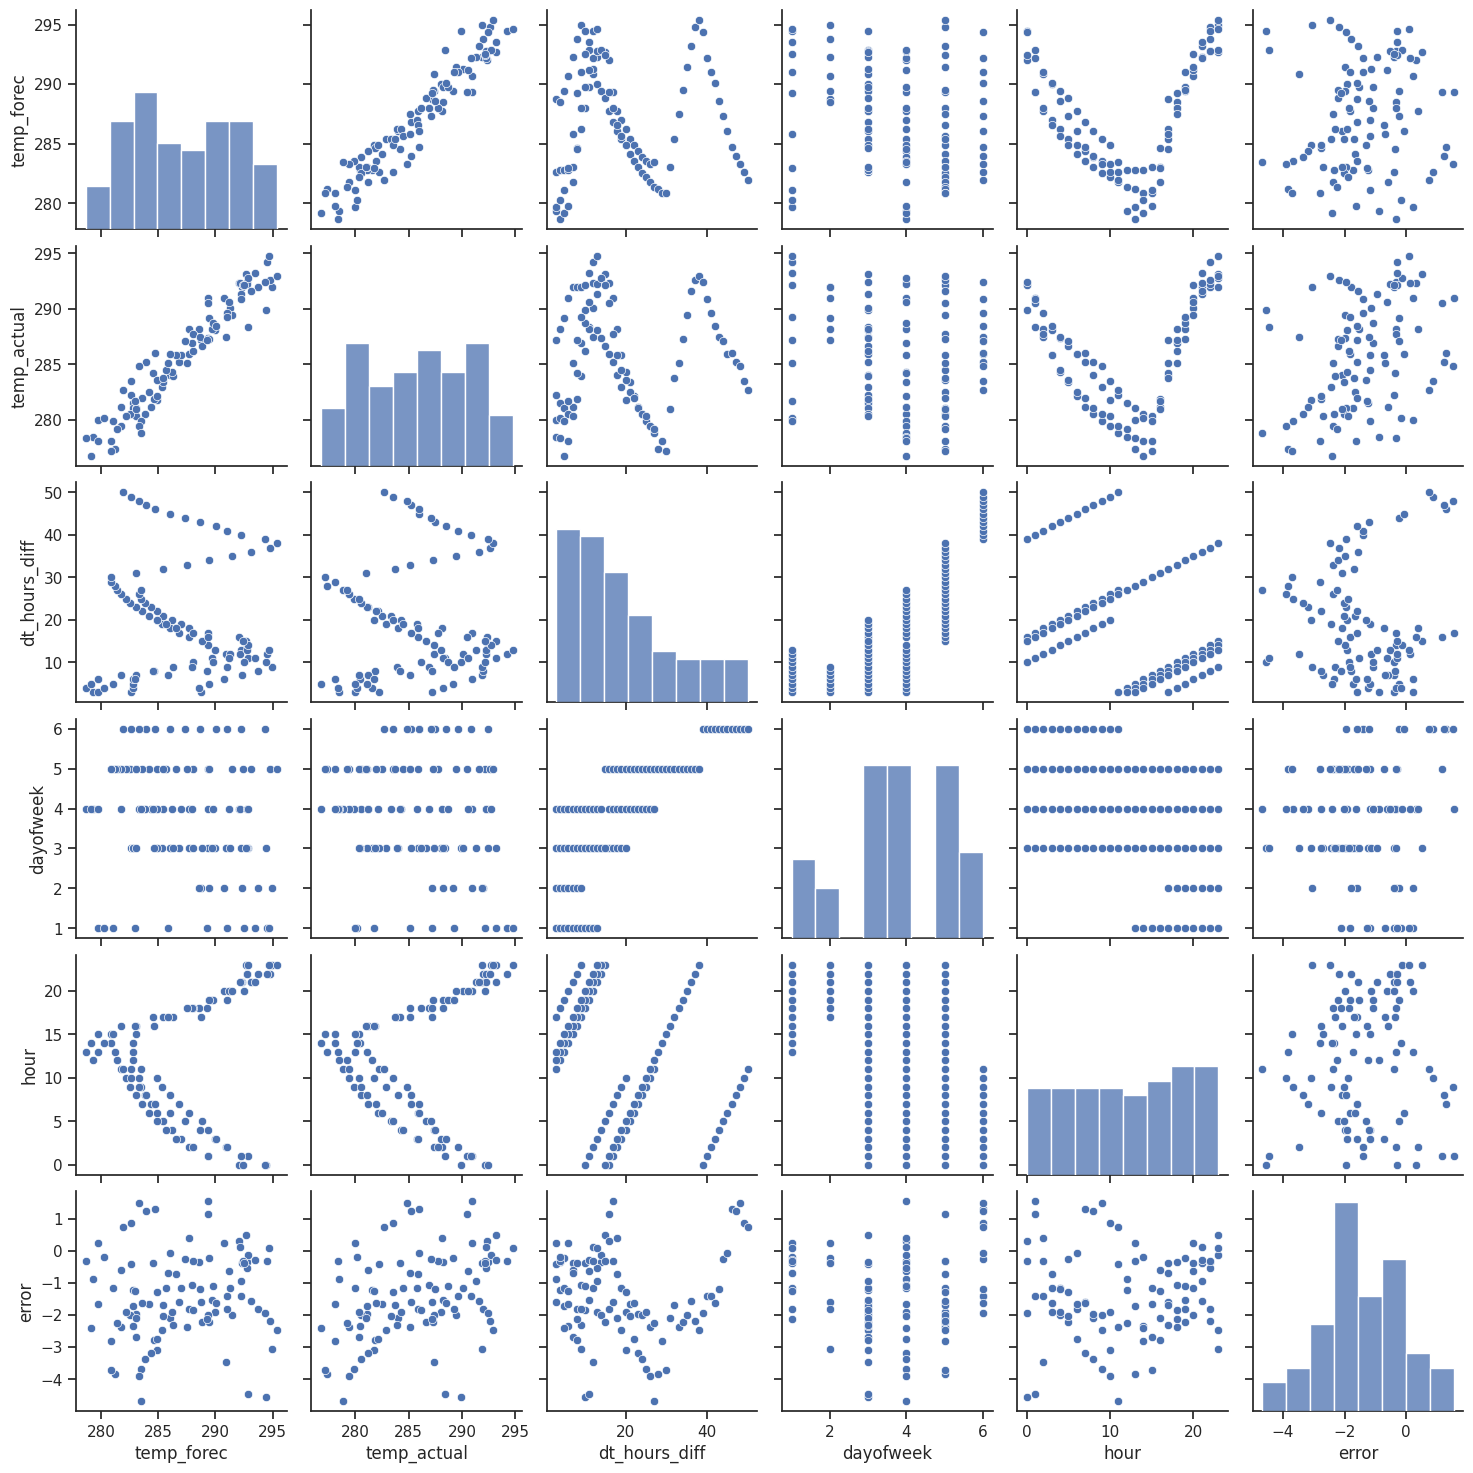

In [38]:
#plot scatter  plot of data
sns.set_theme(style="ticks")

sns.pairplot(df_LA[['temp_forec', 'temp_actual', 'dt_hours_diff', 'dayofweek', 'hour', 'error']])

In [39]:
from sklearn.preprocessing import StandardScaler
#keep only columns 'temp_forec', , 'dt_hours_diff', 'day', and 'hour'
features_to_keep = ['temp_forec', 'dt_hours_diff', 'dayofweek', 'hour', 'error']
target_column = ['temp_actual']

df_xLA = df_LA[features_to_keep].copy()
#normalize data

scaler = StandardScaler()
scaler.fit(df_xLA)
X = scaler.transform(df_xLA)
#
#split data into train and test, using last 20% of the data as test
#df_xtrain = df_xLA.iloc[:int(len(df_LA)*0.8)].copy()
#df_xtest = df_xLA.iloc[-int(len(df_LA)*0.2):].copy()
#split X into train and test, using last 20% of the data as test
X_train = X[:int(len(df_LA)*0.8)]
X_test = X[-int(len(df_LA)*0.2):]

Y = df_LA[target_column].copy().to_numpy().ravel()
y_train = Y[:int(len(df_LA)*0.8)]
y_test = Y[-int(len(df_LA)*0.2):]

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#calculate accuracy
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print('RMSE: ', rmse_lr)

RMSE:  2.2015361458940203e-14


## Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print('RMSE: ', rmse_rf)

RMSE:  1.9971314988002553


In [42]:
df_LA['temp_forec_predictec'] = 0
# to the last 20% of the data add y_pred to temp_forec_predictec
df_LA.iloc[-int(len(df_LA)*0.2):, df_LA.columns.get_loc('temp_forec_predictec')] = y_pred_rf
#df_LA['temp_forec_predictec'] = df_LA.temp_forec - df_LA.temp_forec_predictec
#replace first 80% of temp_forec_predictec with NAN
df_LA.iloc[:int(len(df_LA)*0.8), df_LA.columns.get_loc('temp_forec_predictec')] = np.nan
# replace values below 100 with NaN
df_LA.loc[df_LA.temp_forec_predictec < 100, 'temp_forec_predictec'] = np.nan

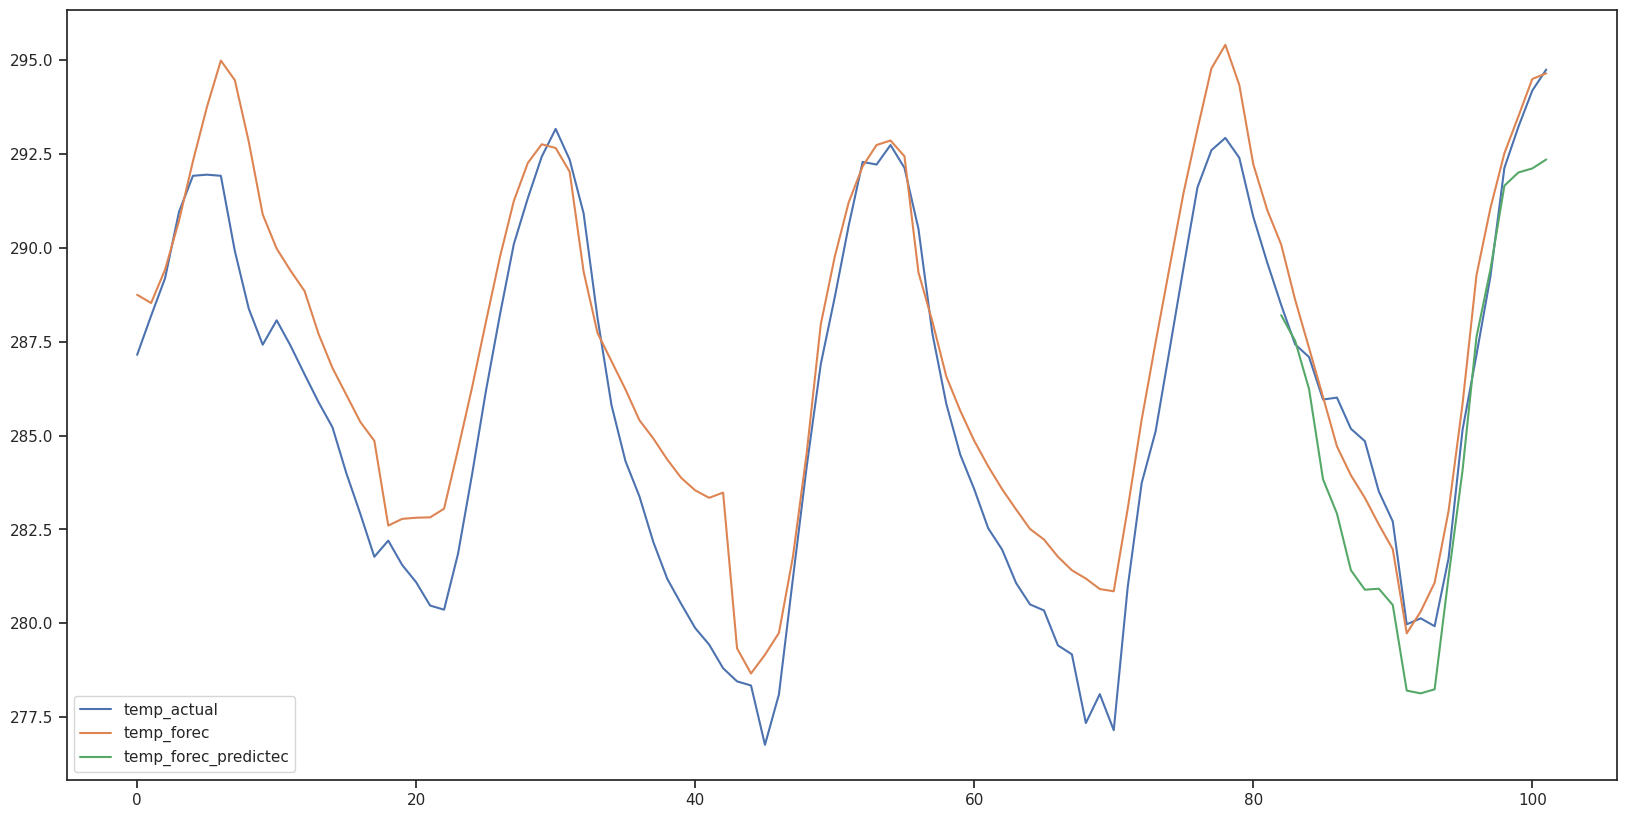

In [43]:
#plot temp_actual from df_LA
plt.figure(figsize=(20,10))
plt.plot(df_LA.temp_actual, label='temp_actual')
plt.plot(df_LA.temp_forec, label='temp_forec')
plt.plot(df_LA.temp_forec_predictec, label='temp_forec_predictec')
#plt.plot(y_pred)
plt.legend()

### Neural Network

In [44]:
from sklearn.neural_network import MLPRegressor
model_nn = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=0)
model_nn.fit(X_train, y_train)
#get accuracy
y_pred_nn = model_nn.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print('RMSE: ', rmse_nn)

RMSE:  107.45614183968038


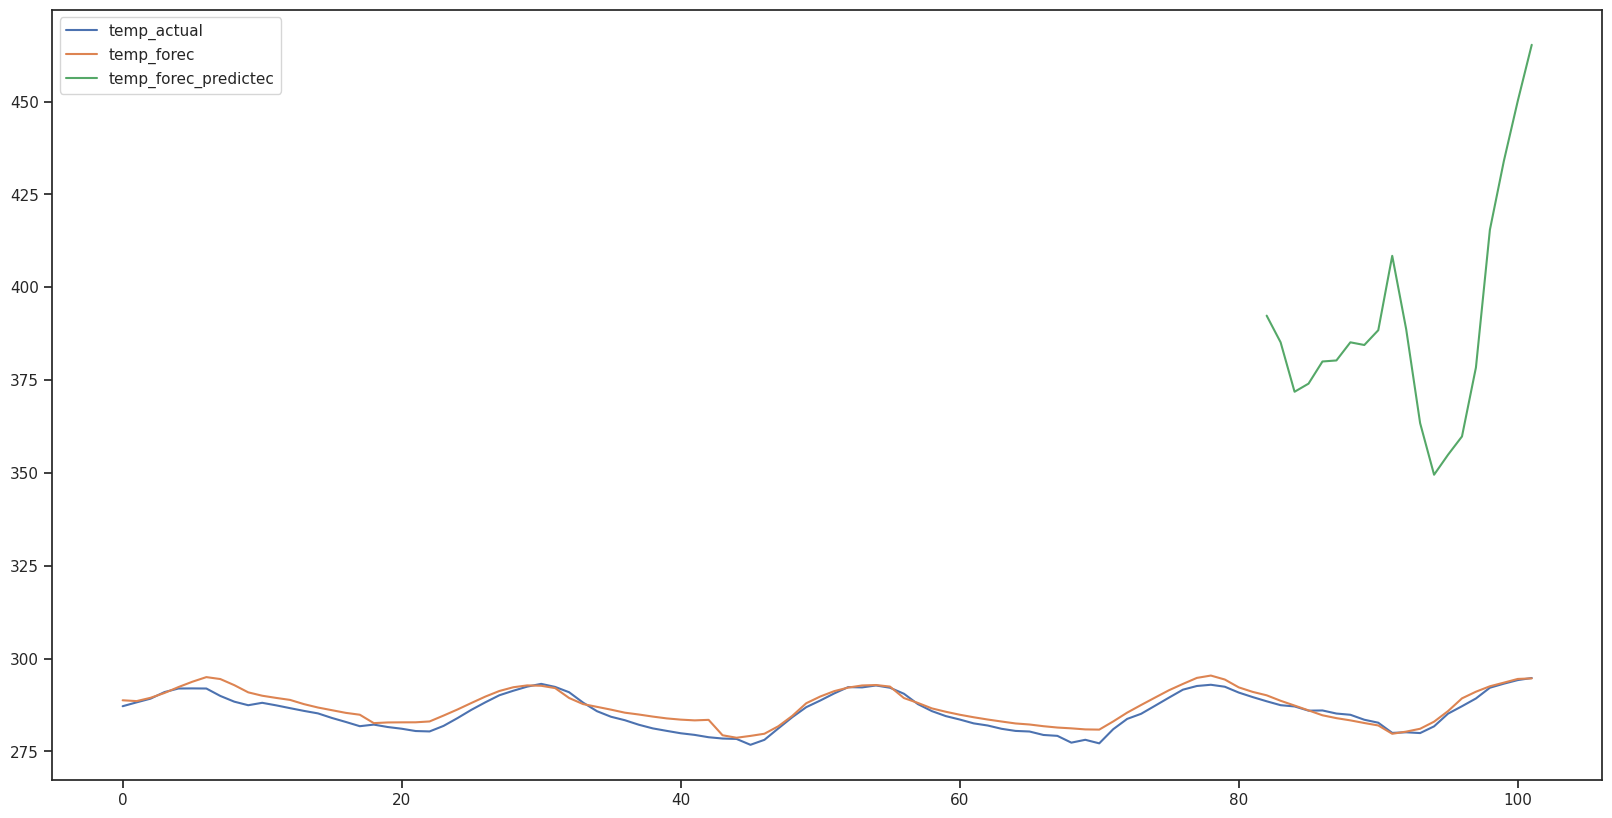

In [45]:
df_LA['temp_forec_predictec'] = 0
# to the last 20% of the data add y_pred to temp_forec_predictec
df_LA.iloc[-int(len(df_LA)*0.2):, df_LA.columns.get_loc('temp_forec_predictec')] = y_pred_nn
#df_LA['temp_forec_predictec'] = df_LA.temp_forec - df_LA.temp_forec_predictec
#replace first 80% of temp_forec_predictec with NAN
df_LA.iloc[:int(len(df_LA)*0.8), df_LA.columns.get_loc('temp_forec_predictec')] = np.nan
# replace values below 100 with NaN
df_LA.loc[df_LA.temp_forec_predictec < 100, 'temp_forec_predictec'] = np.nan
#plot temp_actual from df_LA
plt.figure(figsize=(20,10))
plt.plot(df_LA.temp_actual, label='temp_actual')
plt.plot(df_LA.temp_forec, label='temp_forec')
plt.plot(df_LA.temp_forec_predictec, label='temp_forec_predictec')
#plt.plot(y_pred)
plt.legend()